# Support Vector Machines from Start to Finish

In machine learning, __Support Vector Machines__ (SVMs, also support-vector networks) are supervised learning models to analyze data for classification and regression analysis. Support Vector Machines are one of the best machine learning methods when getting the correct answer is a higher priority than understanding why you get the correct answer. They work really well with relatively small datasets and they tend to work well "out of the box". In other words, they do require much optimization. 

This notebook will use Scikit-Learn to build [Support Vector Machine Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), which uses continuous and categorical data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) to predict whether or not a client will default on their credit card. 

__Table of Contents__
1. Import Modules
2. Import Data
3. Missing Data
4. Downsampling Data
5. Format Data for SVM
6. Building a Preliminary SVM
7. Optimizing Hyper-Parameters
8. Build, Evaluate, Draw, and Interpet the Final SVM

## 1. Import Modules
Load the necessary tools for data manipulation, data visualization, and machine learning.

In [1]:
pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (0.24.0)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd # to load and manipulate data and for one-hot encoding
import numpy as np # to convert data into vectors, compute with them
import matplotlib.pyplot as plt # to draw graphs
import matplotlib.colors as colors
import sklearn # the machine learning module 
from sklearn.utils import resample # to downsample the dataset
from sklearn.model_selection import train_test_split # to split data into training and testing sets
from sklearn.model_selection import GridSearchCV # for parameter optimization
from sklearn.preprocessing import scale # to scale and center the data
from sklearn.svm import SVC # the support vector machine classifier
from sklearn.metrics import confusion_matrix # to create confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot data

In [3]:
print(sklearn.__version__)

0.24.0


## 2. Import Data
This notebook is going to use the __Credit Card Default__ dataset from the UCI Machine Learning Repository. This dataset will allow us to predict if someone will default on their credit card payments based on their demographic data and other metrics.

Load the dataset into a __Pandas dataframe__:

In [4]:
df= pd.read_excel('default_of_credit_card_clients.xls', header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


The dataset contains the following columns:

|Feature Name|Description|
|-----------:|-----------|
|__ID__|ID number assigned to each customer|
|__LIMIT_BAL__|credit card limit in US\$|
|__SEX__|gender (1= male; 2= female)|
|__EDUCATION__|level of education (1= graduate school; 2= university; 3= high school; 4= others)|
|__MARRIAGE__|marital status (1= married; 2= single; 3= others)|
|__AGE__|age in years|
|__PAY__|history of past payment; $n$ trackes the  6 months of payment record (from April to September, 2005); measurement scale for the repayment status is: -1= pay duly, 1= payment delay for one month, 2= payment delay for two months, etc. |
|__BILL_AMT__|amount of the bill in US\$|
|__PAY_AMT__|amount paid in US\$|
|__default payment next month__|whether or not client has defaulted(Yes= 1, No= 0)|


Note that the last column name, __default payment next month__ is too long. Let's change it to __DEFAULT__.

In [5]:
df.rename({'default payment next month':'DEFAULT'}, axis='columns', inplace=True)
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

Also the values in the __ID__ column are randomly assigned, making it uninformative, so we can drop it. 

In [6]:
df.drop('ID',axis=1,inplace=True)
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

## 3. Missing Data
### 3.1 Identification

The first step of the Data Preprocessing is to identify and dealing with missing data. Missing data is simply a blank space, or a surrogate value like __N/A__ that indicates that some entry is missing from the one of the features.

There are two main ways of dealing with missing data:

1. We can remove the rows that contain missing data from the dataset. This is relatively easy to do, but is wastes all of the other values that were collected.
2. We can impute the values that are missing, for instance, with a mean, median, or mode depending on the data type.

Together with identifying the missing data, one must also check if all columns have the correct data type.

In [7]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

All columns are type `int64`, which means there aren't any letters or placeholders mixed in with numbers. Nontheless, we must still check if each column contains acceptable values. The table below describes what values are allowed in each column and is based on the colum description from the [Credit Card Default](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) webpage.

|Feature Name|Description|Variable Data Type|
|-----:|-----|-----|
|__LIMIT_BAL__|credit card limit in USD|_integer_|
|__SEX__|gender (1= male; 2= female)|_category_|
|__EDUCATION__|level of education (1= graduate school; 2= university; 3= high school; 4= others)|_category_|
|__MARRIAGE__|marital status (1= married; 2= single; 3= others)|_category_|
|__AGE__|age in years|_integer_|
|__PAY__|history of past payment; $n$ trackes the  6 months of payment record (from April to September, 2005); measurement scale for the repayment status is: -1= pay duly, 1= payment delay for one month, 2= payment delay for two months, etc. |_category_|
|__BILL_AMT__|amount of the bill in USD|_integer_|
|__PAY_AMT__|amount paid in USD|_integer_|
|__DEFAULT__|whether or not client has defaulted(Yes= 1, No= 0)|_integer_|

Let's start by checking the values of the columns and if necessary convert them; starting with __SEX__.

In [8]:
df['SEX'].unique()

array([2, 1])

Next, __EDUCATION__.

In [9]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

For some unspecified reason, __EDUCATION__ also contains 0,5,6 in addition to the allowed numbers 1,2,3,4. It is possible that 0 represents missing data and 5 & 6 represent categories not mentioned in the specification, but that is just a guess.

Now, let's look at __MARRIAGE__ and make sure it only contains 1,2,3.

In [10]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0])

Like __EDUCATION__; __MARRIAGE__ contains 0, perhaps more missing data.

### 3.2 Dealing with Missing Data

Since Sklearn's SVM do not support datasets with missing values, we need to figure out what to do with the 0s in the dataset. We can either delete these customers from the training dataset, or impute values for the missing data. 

First, let's count the how many rows contain missing data.

In [11]:
len(df.loc[(df['EDUCATION']==0) | (df['MARRIAGE']==0)])

68

In [12]:
len(df)

30000

So __68__ out of __30,000__ rows, or less than 1%, contain missing values. Since that still leaves more than enough data for the SVM, we will remove the rows with missing values rather than imputing them.

In [13]:
df_no_missing= df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]
len(df_no_missing)

29932

In [14]:
df_no_missing['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6])

In [15]:
df_no_missing['MARRIAGE'].unique()

array([1, 2, 3])

## 4. Downsampling Data

SVM are great with small datasets, but awesome with large ones, and this dataset while not huge, is big enough to take some time to optimize with Cross Validation. We will downsample both categories, customers who did and did not default, to __1,000__ each.

In [16]:
df_no_default= df_no_missing[df_no_missing['DEFAULT']==0]
df_default= df_no_missing[df_no_missing['DEFAULT']==1]

Now let's downsample each category:

In [17]:
df_no_default_downsampled= resample(df_no_default,
                                   replace=False,
                                   n_samples=1000,
                                   random_state=42)
len(df_no_default_downsampled)

1000

In [18]:
df_default_downsampled= resample(df_default,
                                   replace=False,
                                   n_samples=1000,
                                   random_state=42)
len(df_default_downsampled)

1000

Now let's re-merge the two downsampled datasets into a single dataframe.

In [19]:
df_downsampled= pd.concat([df_no_default_downsampled, df_default_downsampled])
len(df_downsampled)

2000

## 5. Format Data for SVM
### 5.1 Split the Data into Dependent and Independent Variables

The dependent variable, in conventionel notation $X$ (upper case __X__), contains the columns or features used to make prediction/classification about the independent variable, in conventional notation $y$ (lower case __y__), in this case, whether or not someone default on a credit card payment.

Note: The code below uses `.copy()` to copy the data by value. By default, pandas uses copy by reference. Using `.copy()` ensures that the original data is not modified when formatted into $X$ or $y$.

In [20]:
X= df_downsampled.drop('DEFAULT',axis=1).copy()
print(X.shape)
X.head()

(2000, 23)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [21]:
y= df_downsampled['DEFAULT'].copy()
print(y.shape)
y.head()

(2000,)


641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

### 5.2 One-Hot Encoding
The table below tells us what each variable represents and the type of data it should contain (either _integer_ or _categorical_):

|Feature Name|Description|Variable Data Type|
|-----:|-----|-----|
|__LIMIT_BAL__|credit card limit in USD|_integer_|
|__SEX__|gender (1= male; 2= female)|_category_|
|__EDUCATION__|level of education (1= graduate school; 2= university; 3= high school; 4= others)|_category_|
|__MARRIAGE__|marital status (1= married; 2= single; 3= others)|_category_|
|__AGE__|age in years|_integer_|
|__PAY__|history of past payment; $n$ trackes the  6 months of payment record (from April to September, 2005); measurement scale for the repayment status is: -1= pay duly, 1= payment delay for one month, 2= payment delay for two months, etc. |_category_|
|__BILL_AMT__|amount of the bill in USD|_integer_|
|__PAY_AMT__|amount paid in USD|_integer_|
|__DEFAULT__|whether or not client has defaulted(Yes= 1, No= 0)|_integer_|

__SEX, EDUCATION, MARRIAGE,__ and __PAY__ are supposed to be categorical and need to be modified. This is because Sklearn SVMs natively support continuous data, like __LIMIT_BAL__ and __AGE__, they do not support categorical data. Thus, in order to use categorical data with Sklearn, we have to use a convert each column of categorical data into multiple columns of binary values (aka dummy variables). This is called __One-Hot Encoding__.

Let's look at the example of __MARRIAGE__ as categorical data, which contains 3 options: 1=Married; 2=Single; 3=Other. As is, the SVM would treat them as continuous data meaning that it would be more likely to cluster the people with 3s and 2s together than the people with 3s and 1s together. In contrast, if these numbers are treated as categorical data, then the SVM would treat each one as a separate category that is no more or less similar to any of the other categories. Thus, the likelihood of clustering people with 3s and 2s is the same as clustering people with 3s and 1s, and that approach is more reasonable.

There are many different ways to do __One-Hot Encoding__ in Python. Two common methods are `ColumnTransformer()` from Sklearn and `get_dummies()` from Pandas. Both have merits and demerits. The `ColumnTransformer()` can create a persistent function that can validate data that you can get in the future. The downside is that `ColumnTransformer()` turns your data into an array and looses all the column names, making it harder to verify if the transformation worked as intended. By contrast, `get_dummies()` leaves your data in dataframe and retains column names, making it easier to verify if it worked as intended. However, `get_dummies()` does not have the persistent behavior that `ColumnTransformer()` has.

This notebook uses Pandas' `get_dummies()` for __One-Hot Encoding__. 

In [22]:
X_encoded= pd.get_dummies(X, columns=['SEX',
                                      'EDUCATION',
                                      'MARRIAGE',
                                      'PAY_0',
                                      'PAY_2',
                                      'PAY_3',
                                      'PAY_4',
                                      'PAY_5',
                                      'PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,...,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,...,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,...,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,...,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,...,0,0,0,1,0,0,0,0,0,0


### 5.3 Centering and Scaling
The __Radial Basis Function (RBF)__ that we will be using with the SVM assumes that the data are centered and scaled. In other words, each column should have a mean=0 and a standard deviation=1. The Sklearn function `scale()` does this. It needs to be applies to both the training and the testing set. 

To avoid __Data Leakage__, the dataset is split first and then they are scaled separately. Data Leakage occurs when information about the training dataset corrupts or influences the testing set (that is to say spills or leakes over).

In [23]:
X_train, X_test, y_train, y_test= train_test_split(X_encoded, y, random_state=42)
X_train_scaled= scale(X_train)
X_test_scaled= scale(X_test)

## 6. Build a Preliminary Support Vector Machine

In [24]:
clf_svm= SVC(random_state=42,kernel='rbf')
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

A preliminary Support Vector Machine for classification has been built. Check its performance on the testing data and draw a __Confusion Matrix__:

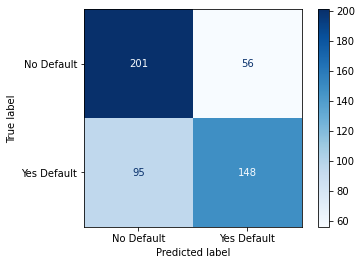

In [25]:
plot_confusion_matrix(clf_svm,
                     X_test_scaled,
                     y_test,
                     values_format='d',
                     display_labels=['No Default', 'Yes Default'],
                     cmap=plt.cm.Blues);

In the confusion matrix, we  see that of the __201+56=257__ people that did not default, __201 (79%)__ were correctly classified. And of the __95+148=243__ people that did default, __148 (61%)__ were correctly classified. So the Support Vector Machine was not perfect. These outcomes may be improved by __Cross Validation__ to optimize the hyper-parameters.

----

## 7. Optimizing Hyper-Parameters

Optimizimg a Support Vector Machine is all about the best value for __gamma__, and potentially the regularization parameter __C__; also known as hyper-parameters. Let's see if we can find better values with __Cross Validation__ in hope to improve the accuracy on the testing set.

Since we have two parameters to optimize, we will use Sklearn's `GridSearchCV()`. Moreover, we need to specify potential values for __gamma__ and __C__ for `GridSearchCV()` to test all possible combinations of the parameters for us.

In [26]:
param_grid=[
    {'C': [0.5, 1, 10, 100], # C must be > 0
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]
# NOTE: C=1 and gamma='scale' are included because they are the default values

optimal_params= GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        scoring='accuracy',
        ## Other scoring options: 'balanced-accuracy', 'f1', 'f1_weighted', 'roc_auc'
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        verbose=0 # NOTE: if you want to see GridSearchCV at work, set verbose=2
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


The ideal value for `C` is __100__, which means we will use the regularization, and the ideal value for `gamma` is __0.001__.

----

## 8. Build, Evaluate, Draw, and Interpet the Final SVM
These optimal parameters can be used to build the fina __Support Vector Machine__.

In [27]:
clf_svm= SVC(random_state=42, C=100, gamma=0.001, kernel='rbf')
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

Draw another Confusion Matrix to see if the optimized SVM does better on the testing data.

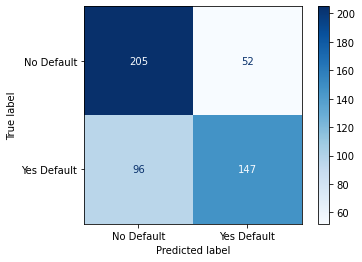

In [28]:
plot_confusion_matrix(clf_svm,
                     X_test_scaled,
                     y_test,
                     values_format='d',
                     display_labels=['No Default', 'Yes Default'],
                     cmap=plt.cm.Blues);

And the results from the _optimized_ SVM are just a little bit better than before. __4__ more people were _correctly_ classified as not defaulting and only __1__ more person was _incorrectly_ classified as defaulting.

In other words, the SVM was good straight out of the box without much optimization. This makes SVMs a great and quick method for classifications on small datasets.

The last thing about SVMs is the so-called __Decision Boundary__. Let's visualize it and discuss how to interpret it.

In [29]:
# obtain the number of columns in X
len(df_downsampled.columns)

24

There are __24__ features or columns in $X$. This is a problem because it would require a 24-dimensional graph, one dimension per feature used to make predictions, to plot the data in its raw form. In order to meaningfully reduce those 24 features to just 2 features for visualization, we will employ __Principal Component Analysis  (PCA)__. This will combine 24 raw features into __2 orthogonal meta-features__. 

However, before we shrink the feature set, let's first estimate how accurate the shrunken 2-feature graph will be. We can determine the accuracy of the graph by drawing a so-called __scree plot__. To produce an accurate 2-dimensional graph later, we expect the first 2 principal components to stand out over the rest on the scree plot, i.e. have a higher percentage of explained variance than the rest of the components.

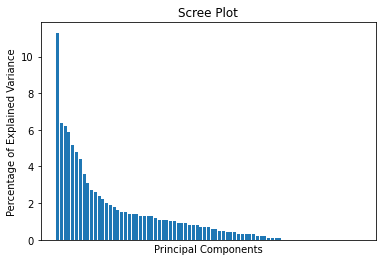

In [30]:
pca= PCA() # by default, PCA centers the data but doesn't scale it
X_train_pca= pca.fit_transform(X_train_scaled)

per_var= np.round(pca.explained_variance_ratio_*100, decimals=1)
labels= [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(axis='x', # changes apply to x-axis
               which='both', # both major & minor ticks 
               bottom=False, # ticks along bottom edge are off
               top=False,    # ticks along top edge are off
               labelbottom=False) # labels along bottom edge are off
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show();

The scree plot shows that the first principal component, PC1, accounts for a relatively large amount of variation in the raw data. This mean that it will be a good candidate for the x-axis in the 2 dimensional graph. However, PC2 is not much different from PC3 or PC4, which doesn't bode well for dimension reduction. Since we don't have another choice, let's go with PC1 and PC2. (The final graph may be a look funky).

Now draw the PCA graph, after training and optimizing the SVM for PC1 and PC2. 

In [31]:
train_pc1_coords= X_train_pca[:,0]
train_pc2_coords= X_train_pca[:,1]
## pc1 contains the x-axis coordinates of the data after PCA
## pc2 contains the y-axis coordinates of the data after PCA

# center and scale the PCs
pca_train_scaled= scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

# GridSearchCV optimize the SVM fit PC1 and PC2
param_grid= [
    {'C':[1,10,100,1000],
    'gamma':['scale',1,0.1,0.01,0.001,0.0001],
    'kernel':['rbf']},]

optimal_params= GridSearchCV(SVC(),
                            param_grid,
                            cv=5,
                            scoring='accuracy',
                            verbose=0)
optimal_params.fit(pca_train_scaled,y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


We received different optimal parameters because we used a different dataset than before. Now, the optimal value for `C` is __1000__ and for `gamma` is __0.001__. 

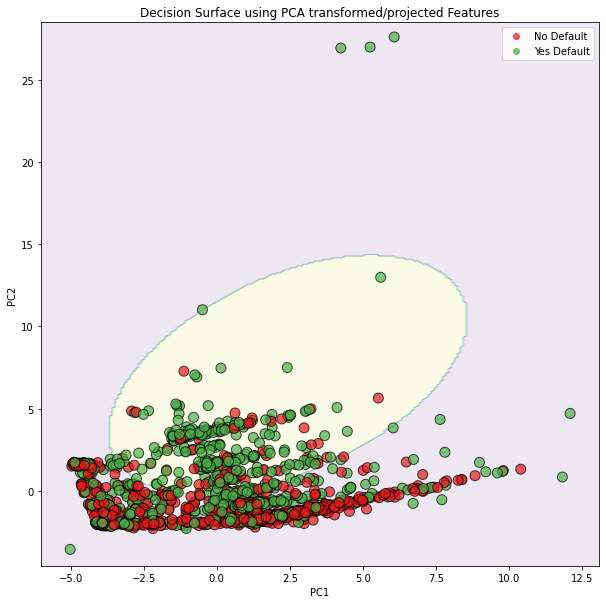

In [32]:
clf_svm= SVC(random_state=42, C=1000, gamma=0.001, kernel='rbf')
clf_svm.fit(pca_train_scaled,y_train)

## transform the the test data with PCA
X_test_pca= pca.transform(X_train_scaled) 
# X_test_pca= pca.transform(X_test_scaled)
test_pc1_coords= X_test_pca[:,0]
test_pc2_coords= X_test_pca[:,1]

## now create the matrix of points that we can use to show as decision region
## the matrix boundaroes need to be mapped so points don't go over the edge
x_min= test_pc1_coords.min()-1
x_max= test_pc1_coords.max()+1

y_min= test_pc2_coords.min()-1
y_max= test_pc2_coords.max()+1

xx, yy= np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                    np.arange(start=y_min, stop=y_max, step=0.1))

## now we will classify each point in that matrix with the SVM
Z= clf_svm.predict(np.column_stack((xx.ravel(),yy.ravel())))
## Z is a long array of 1s and 0s,
## which reflect how each point in the mesh grid was classified
## .reshape() will realign them with the matrix
Z= Z.reshape(xx.shape)

## the filled contour plot (ax.contourf)
## will be filled according to the predicted classification in Z
fig,ax= plt.subplots(figsize=(10,10))
ax.contourf(xx,yy,Z, alpha=0.1)
cmap= colors.ListedColormap(['#e41a1c','#4daf4a'])
## now draw the actual data points
scatter= ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train,
# scatter= ax.scatter(test_pc1_coords, test_pc2_coords, c=y_test,
                   cmap=cmap,
                   s=100,
                   edgecolor='k',
                   alpha=0.7)
## create a legend
legend= ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elements()[1],
                 loc='upper right')
legend.get_texts()[0].set_text('No Default')
legend.get_texts()[1].set_text('Yes Default')
# label axes, add title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Decision Surface using PCA transformed/projected Features')
plt.show();

The PCA graph shows the the decision boundary of the SVM on the training dataset. Principal Component Analysis has reduced the initial 24 features from the raw data down to 2 meta-features for visualization of the decision boundary/surface. Here, the decision surface has a circular form. Within the yellow circle are people that are more likely to have defaulted on their Credit Card Payments (green points) and outside the circle are more likely to have not defaulted (red points).